# Variational Principle method

This notebook follows (Thijssen, 2013, p. 29). The variational method is a method for deducing upper bounds of energy eigenstates (usually used on the ground state). 

## Theory 

Consider a subset of Hilbert space whose energy expectation values are greater than some eigenstate's energy that we want to find. It can be shown that the min energy expectation value of any superposition of these states is greater than or equal to the eigenenergy we want (see (Thijssen, 2013, p. 30) for the full proof or (Griffiths, 2018, p. 327) for the simple case).

In the linear case this can be reformed into a matrix problem.

If the subset of states is $\{\ket{n}|n=1,2,3,...\}$ (this set doesn't have to be orthonormal), then a general ket takes the form:

$\ket{\phi} = \sum\limits_{i = 1}^{\infty}C_i\ket{i}$

$\implies \bra{\phi}\hat{H}\ket{\phi} = \dfrac{\sum\limits_{i,j = 1}^{\infty}C_i^{*}C_jH_{ij}}{\sum\limits_{i,j = 1}^{\infty}C_i^{*}C_jS_{ij}}$

where $H_{ij} = \bra{i}\hat{H}\ket{j}$ and $S_{ij} = \bra{i}\hat{S}\ket{j}$

Minimising $\bra{\phi}\hat{H}\ket{\phi}$ by calculus gives:

$\sum\limits_{j = 1}^{\infty}C_j(H_{ij} - E S_{ij})$ for all i

This can be rewritten as a matrix equation $\bf{H}\bf{C} = E \bf{S}\bf{C}$

## Linear variational method for the Hydrogen atom

In atomic units the time-independent Schrödinger equation is:

$(\frac{1}{2}\nabla^2 - \frac{1}{r})\psi(\vec{r}) = E\psi(\vec{r})$

Apply the linear variational principle method, where the guessed wavefunction is a linear superposition of:

$\psi_{\alpha_n}(\vec{r}) = e^{-\alpha_n r^2}$

where $\alpha \in \{ \alpha_1 = 13.00773, \alpha_2 = 1.962079, \alpha_3 = 0.444529, \alpha_4 = 0.1219492 \}$

The corresponding matrix elements are:

$S_{nm} = \left( \frac{\pi}{\alpha_n + \alpha_m} \right)^{\frac{3}{2}}$

$H_{nm} = 3\frac{\alpha_n\alpha_m\pi^{\frac{3}{2}}}{(\alpha_n + \alpha_m)^{\frac{5}{2}}} - \frac{2\pi}{\alpha_n + \alpha_m}$

The following program implements this approach.

In [2]:
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import fmin
import matplotlib.pyplot as plt


In [3]:

#functions that calculate components 
def Sij(alpha_i,alpha_j):
    return (np.pi/(alpha_i + alpha_j))**1.5

def Hij(alpha_i,alpha_j):
    return 3*(alpha_i*alpha_j*(np.pi**1.5))/((alpha_i + alpha_j)**(5/2)) - 2*np.pi/(alpha_i + alpha_j)


#values of alpha
alphas_H = np.array([13.00773, 1.962079, 0.444529, 0.1219492])

def findHydrogenGroundState(alphas):
        
    #finding matrices as lists
    S = np.array([[Sij(a_i,a_j) for a_i in alphas] for a_j in alphas])
    H = np.array([[Hij(a_i,a_j) for a_i in alphas] for a_j in alphas])

    #find eigenvalues
    eigenvalues, eigenvectors = eigh(H,S)

    return eigenvalues[0], eigenvectors[0]#/(eigenvectors[0] @ S @ eigenvectors[0])


def findHydrogenGroundEnergy(alphas):
    
    eigenvalues, eigenvectors = findHydrogenGroundState(alphas) #better names
    
    return eigenvalues


In [4]:
#ground state calculation
groundEnergy = findHydrogenGroundEnergy(alphas_H)
print(f"Ground energy is {groundEnergy} hartree. The correct value is -0.5 hartree.")

Ground energy is -0.49927840566748466 hartree. The correct value is -0.5 hartree.


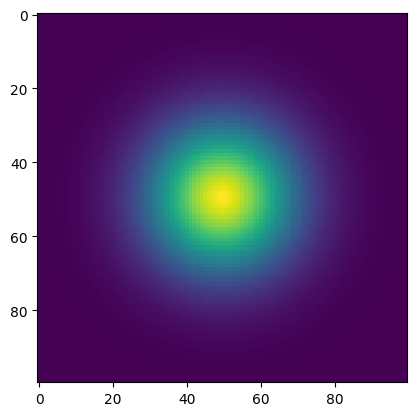

In [5]:
#excited states can't be found with just spherical basis (unless you approximated by shifting positions)
#hence only the ground state can be described 

energy_H, states_H = findHydrogenGroundState(alphas_H) #better name for states?

def getProbDensity(contractionCoeff,alphas,halfWidth,N): #z=0
    x = np.linspace(-halfWidth, halfWidth, N)
    y = np.linspace(-halfWidth, halfWidth, N)
    xv, yv = np.meshgrid(x, y)

    wavefunction = np.zeros((N,N))
    for i in range(alphas.shape[0]):
        wavefunction +=  contractionCoeff[i]*np.exp(-alphas[i]*(xv**2 + yv**2))

    return wavefunction**2

plt.imshow(getProbDensity(states_H,alphas_H,5,100))
plt.title("Density plot of a hydrogen atom in z=0 plane")
plt.xlabel("x")
plt.ylabel("y")

In [37]:
#look at Kopmann theorm for Helium

#Self-Consistent Molecular Orbital Methods. VI. Energy Optimized Gaussian Atomic Orbitals
#"Direct Search" Solution of Numerical and Statistical Problems*

#this method could be generalised, though other methods are more efficient
#when combined with the linear method above it solves the non-linear problem
#this is good method as its easy to take into account contraints on the problem (eg alphas can't be negative)
#more computationally efficient method would start with larger deltas and decrease the size
#can run into problems with equal alpha values being generated but with decent seperation this usually is fine


def getNewAlphasByDirectSearch(alphas,delta,depth=0):
    """
    Function takes an intial guess of the alphas and applies the direct search method recursively to find the 
    alphas that minimise the ground state energy.

    Inputs:
    alphas - inital guess alpha array
    delta -  accuracy to which the direct search method will be applied 
    depth - depth of recursion
    """

    dim = alphas.shape[0]
    assert np.all(alphas > np.zeros(dim))
    assert np.unique(alphas).shape[0] == dim

    newAlphas = np.copy(alphas)
    for i in range(dim):
        alphasUp = np.copy(alphas)
        alphasUp[i] += delta

        alphasDown = np.copy(alphas)
        #as alphas have to be positive 
        if alphasDown[i] <= delta:
            alphasDown[i] /= 2
        else:
            alphasDown[i] -= delta

        E = findHydrogenGroundEnergy(alphas)
        EUp = findHydrogenGroundEnergy(alphasUp)
        EDown = findHydrogenGroundEnergy(alphasDown)

        if EUp-E >= 0 and EDown - E >= 0:
            pass
        elif EUp - E > 0:
            newAlphas[i] = alphasDown[i]
        elif EUp - E <= 0:
            newAlphas[i] = alphasUp[i]
    
    #muliplication by 1.1 is to allow alphas difference to be on the edge
    if np.allclose(newAlphas,alphas,rtol=1.1*delta): 
        return newAlphas
    elif depth == 999:
        print("max depth reached")
        return newAlphas
    else:
        return getNewAlphasByDirectSearch(newAlphas,delta,depth+1)


def getNewAlphas(intialAlphas,deltaInital,n):
    """
    Function that takes an intial guess for the alphas and applies the direct search method recursively 
    for smaller and smaller deltas. Assumes deltaInital is less that 1.
    """
    alphas = np.copy(intialAlphas)
    delta = deltaInital
    for i in range(n):
        alphas = getNewAlphasByDirectSearch(alphas,delta)
        delta *= deltaInital
    return alphas



intialAlphaGuess = np.array([17, 1, 1.5, 2])
for i in range(1,5):
    newAlphas = getNewAlphas(intialAlphaGuess,0.1,i)
    print(f"Energy found is  {findHydrogenGroundEnergy(newAlphas)}, the alpha accuracy used is {np.round(0.1**(i),i)}")




Energy found is  -0.32961354366849316, the alpha accuracy used is 0.1
Energy found is  -0.49898344123840493, the alpha accuracy used is 0.01
Energy found is  -0.4990131865331641, the alpha accuracy used is 0.001
Energy found is  -0.4990177440121908, the alpha accuracy used is 0.0001


## Helium atom 

Via the Born-Oppenheimer, the Helium atom Hamiltonian is:

$\hat{H} = -\frac{1}{2}\nabla_1^2 -\frac{1}{2}\nabla_2^2 + \frac{1}{|\vec{r_1} - \vec{r_2}|}  - \frac{2}{r_1} - \frac{2}{r_2}$

As the ground state energy is in a singlet spin state, the position part of the wavefunction is $\psi (\vec{r_1},\vec{r_2}) = \phi (\vec{r_1})\phi (\vec{r_2})$. Assuming that $\phi (\vec{r})$ is normalised, it can be shown that (Thijssen, 2013, p. 46):

$(-\frac{1}{2}\nabla_1^2 - \frac{2}{r_1} + \int dV_2 \frac{|\phi{\vec{r_2}}|^2}{|\vec{r_1} - \vec{r_2}|})\phi(\vec{r_1}) = E\phi(\vec{r_1})$

This equation cannot be solved exactly. However, we can get an upper bound using the linear variational method described above. Using the same $\psi_{\alpha_n}(\vec{r})$ with different values of $\alpha$, this can be reformulated into a matrix problem:

$\sum\limits_{q}(h_{pq} + \sum\limits_{r,s}C_s C_r Q_{prqs})C_q = E\sum\limits_{q} S_{pq}C_q$

where

$h_{pq} = \bra{\psi_{\alpha_p}}-\frac{1}{2}\nabla^2 - \frac{2}{r}\ket{\psi_{\alpha_p}}$

$Q_{prqs} = \int dV_1 dV_2 \frac{\psi_{\alpha_p}(\vec{r_1})\psi_{\alpha_r}(\vec{r_2})\psi_{\alpha_q}(\vec{r_1})\psi_{\alpha_s}(\vec{r_2})}{|\vec{r_1}-\vec{r_2}|}$

$S_{pq} = \bra{\psi_{\alpha_p}}\ket{\psi_{\alpha_q}}$

This can be solved by guessing the $C$ values, plugging them into the $Q$ part of the expression and solving the eigenvalue equation produced. The process can then be repeated recursively with the $C$ s found until the error is below some specified value (works because the ground state energy is a stable fixed point under this map).

The ground state energy can then be deduced from:

$E_G = 2\sum\limits_{p,q}C_p C_q h_{pq} +\sum\limits_{p,q,r,s} Q_{prqs}C_p C_q C_s C_r$

This process is implemented below.

In [7]:
#simulation parameters
alphas2 = [0.298073, 1.242567, 5.782948, 38.47497]


In [8]:
#functions to calculate matrix elements 

def Qijkl(alpha_i,alpha_j,alpha_k,alpha_l):
    """
    Calculates the components of the Q matrix.
    """
    denominator = (alpha_i + alpha_k)*(alpha_j + alpha_l)*((alpha_i + alpha_j + alpha_k + alpha_l)**0.5)
    return 2*(np.pi**2.5)/denominator

def hij(alpha_i,alpha_j):
    """
    Finds components of h matrix
    """
    return (3*alpha_i*alpha_j*(np.pi**1.5))/((alpha_i + alpha_j)**2.5) -  4*np.pi/(alpha_i + alpha_j)



In [9]:
#find matricies
h = np.zeros((4, 4))
S2 = np.zeros((4, 4))
Q = np.zeros((4, 4, 4, 4))

for i in range(4):
    for j in range(4):
        h[i,j] = hij(alphas2[i],alphas2[j])
        S2[i,j] = Sij(alphas2[i], alphas2[j])
        for k in range(4):
            for l in range(4):
                Q[i, j, k, l]= Qijkl(alphas2[i],alphas2[j],alphas2[k],alphas2[l])



In [10]:

#normalisation function 
def normalise(C):
    """
    Normalises C (remember that the set doesn't have to be orthonomal so this is not trivial)
    """
    innerProduct = 0
    for i,c_i in enumerate(C):
        for j,c_j in enumerate(C):
            innerProduct += c_i*c_j*S2[i][j]

    return C/(innerProduct**0.5)  



In [11]:
#intial guess
CGuess = normalise(np.array([1, 1, 1, 1])) 
EGuess = 0

#run simulation
def iterateC(C,EPrev):
    """
    Performs one iteration of the recursive cycle   
    """
    #finds F matrix
    F = h + np.einsum('ikjl,k,l', Q, C, C) 

    #finds new C values
    eigenvalues, eignestates = eigh(F,S2,eigvals_only=False)
    CNew = normalise(eignestates[:,0])

    #find E
    groundEnergyFound =  2*np.einsum('ij,i,j', h, CNew, CNew) + np.einsum('ikjl,i,j,k,l', Q, CNew, CNew, CNew, CNew)
    
    #iterates agian if difference between previous iteration is not less than max error
    if abs(groundEnergyFound - EPrev) < 1E-14:
        return groundEnergyFound 
    else:
        return iterateC(CNew,groundEnergyFound)

print(f"Ground energy is {iterateC(CGuess,EGuess)} hartree. The correct value is -2.903 hartree.")

Ground energy is -2.8551603823702516 hartree. The correct value is -2.903 hartree.


## References

Thijseen J., 2013. Computational Physics. Cambridge: Cambridge University Press

Griffiths D., 2018. Introduction To Quantum Mechanics.  Cambridge: Cambridge University Press